# Bike Sharing Assignment
## Problem Statement
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Step1 - Read dataset

In [4]:
# import dataset
bikesharing = pd.read_csv('day.csv')

In [5]:
# get the saape
bikesharing.shape

(730, 16)

In [6]:
# get the info
bikesharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
# get a look at data
bikesharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Clean Unwanted Data
- instant is row number
- dteday information is already captured in yr, month and weekday columns
- cnt hold the sum of casual and registered

In [9]:
# Drop instant, dteday, casual and registered columns
unwanted_cols = ['instant','dteday','casual','registered']
bikesharing.drop(unwanted_cols, axis=1, inplace=True)

In [10]:
# Drop duplicate records if any
bikesharing.drop_duplicates(inplace=True)

In [11]:
bikesharing.shape

(730, 12)

- There are no duplicates in dataset

### Set Categorical Column Values

In [14]:
bikesharing['season'] = bikesharing['season'].replace({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bikesharing['mnth'] = bikesharing['mnth'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
bikesharing['weekday'] = bikesharing['weekday'].replace({5:'Sun',6:'Mon',0:'Tue',1:'Wed',2:'Thu',3:'Fri',4:'Sat'})
bikesharing['weathersit'] = bikesharing['weathersit'].replace({1:'Clear',2:'Mist',3:'LightRain',4:'HeavyRain'})

In [15]:
bikesharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


In [16]:
# Create a list of numerical and categorical variables
num_cols = ['temp','atemp','hum','windspeed']
cat_cols = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

### Visualizing & undestanding data

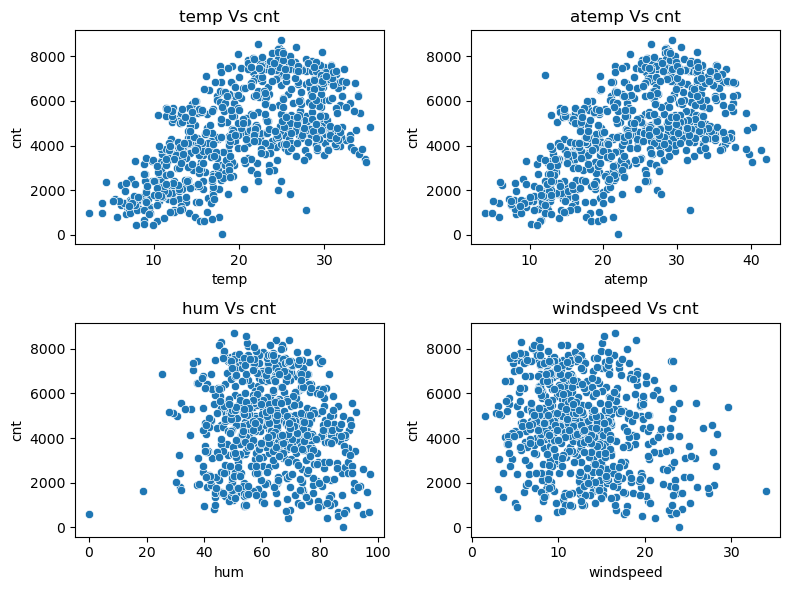

In [18]:
# Lets plot numerical variables with total number of bike rentals 'cnt'
plt.figure(figsize=(8, 6))
i = 1
for var in num_cols:
    plt.subplot(2,2,i)
    sns.scatterplot(data=bikesharing,x=var,y='cnt').set_title(var + ' Vs cnt')
    plt.tight_layout()
    i = i + 1

- From above plots, temp and atemp seem to have positive and linear correlation with cnt


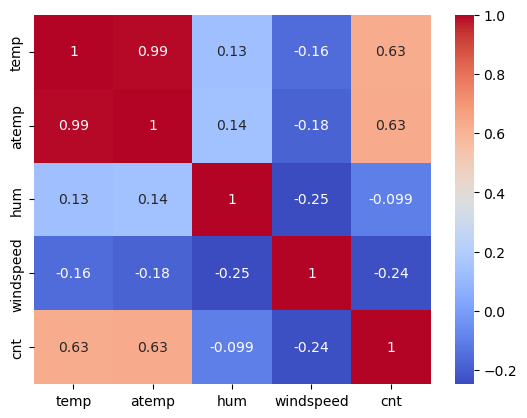

In [20]:
# Plot a heatmap to find correlation among numerical variables
sns.heatmap(bikesharing[['temp','atemp','hum','windspeed','cnt']].corr(),annot=True, cmap='coolwarm')
plt.show()

- From the heatmap it is clear that temp and atemp are highly correlated
- temp and atemp has high positive correlation with cnt

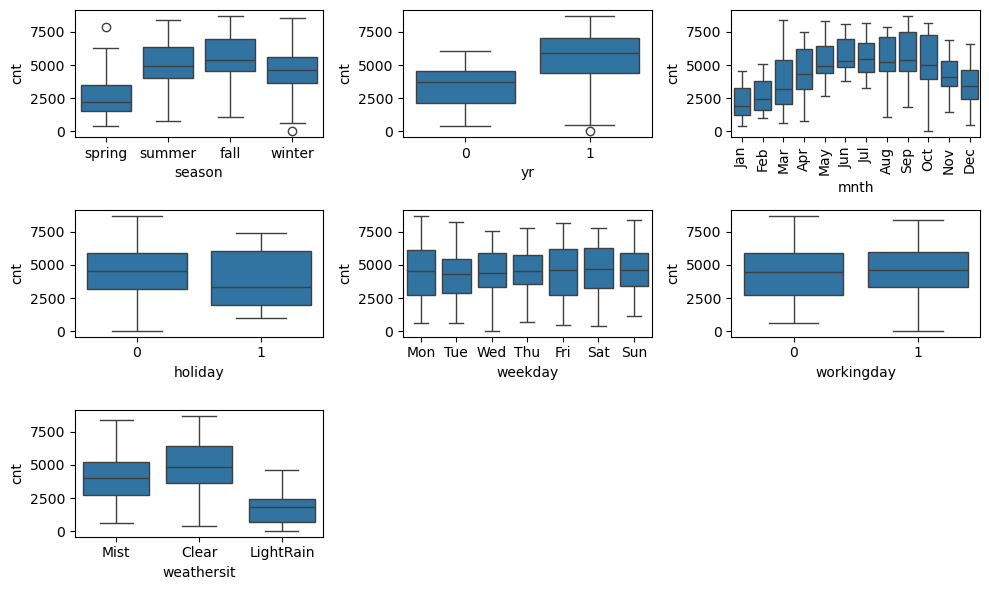

In [22]:
## Check boxplots for categorical variables
plt.figure(figsize=(10, 6))
i = 1
for var in cat_cols:
    plt.subplot(3,3,i)
    plot = sns.boxplot(data=bikesharing,x=var,y='cnt')
    if i == 3:
        plt.setp(plot.get_xticklabels(), rotation=90)
    plt.tight_layout()
    i = i + 1

- Bike rentals are increased in summer and fall season as compared to spring and winter
- Bike rentals are increased significantly in year 2019 than year 2018
- Bike rentals increased from Jan to May, peaked between May to Oct and decreased from Nov to Dec in each year
- On holidays rental count has slightly dropped
- There is no significant change as per weekday or weekends on rental counts
- There is no significant difference in rental counts for working and non working days
- Clear weather attracted most bikers to rent bike. During heavy rain not a single bike got rented, which is quite obvious. 

## Setp2 - Data Preparation

In [25]:
# Drop atemp as it is highly correlated with temp
bikesharing.drop(['atemp'],axis=1,inplace=True)

In [26]:
# Get dummy variables for categorical variables
dummies = pd.get_dummies(bikesharing[['season','mnth','weekday','weathersit']],dtype=int,drop_first=True)

In [27]:
# Add dummy variables to bikesharing dataframe and remove season, mnth, weekday and weathersit columns
bikesharing = pd.concat([bikesharing,dummies],axis=1)
bikesharing.drop(['season', 'mnth', 'weekday', 'weathersit'],axis=1,inplace=True)

- Now bikesharing dataframe has all numerical columns

### Split data in train and test set

In [30]:
# spliting train and test sets into 70:30 ratio
np.random.seed(0)
bs_train, bs_test = train_test_split(bikesharing, train_size=0.7, test_size=0.3, random_state=100)

In [31]:
# Check size
print(bs_train.shape)
print(bs_test.shape)

(510, 29)
(219, 29)


### Scaling data

In [33]:
# Normalize data with MinMaxScaler
scaler = MinMaxScaler()

# Applying scaling to continuous variables of training set
continuous_vars = ['temp','hum','windspeed','cnt']
bs_train[continuous_vars] = scaler.fit_transform(bs_train[continuous_vars])

In [34]:
bs_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightRain,weathersit_Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,...,0.086275,0.080392,0.154902,0.133333,0.127451,0.131373,0.143137,0.150980,0.029412,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,...,0.281045,0.272166,0.362166,0.340268,0.333805,0.338139,0.350557,0.358381,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Now every column in bs_train is scaled from 0 to 1

### Checking for correlation

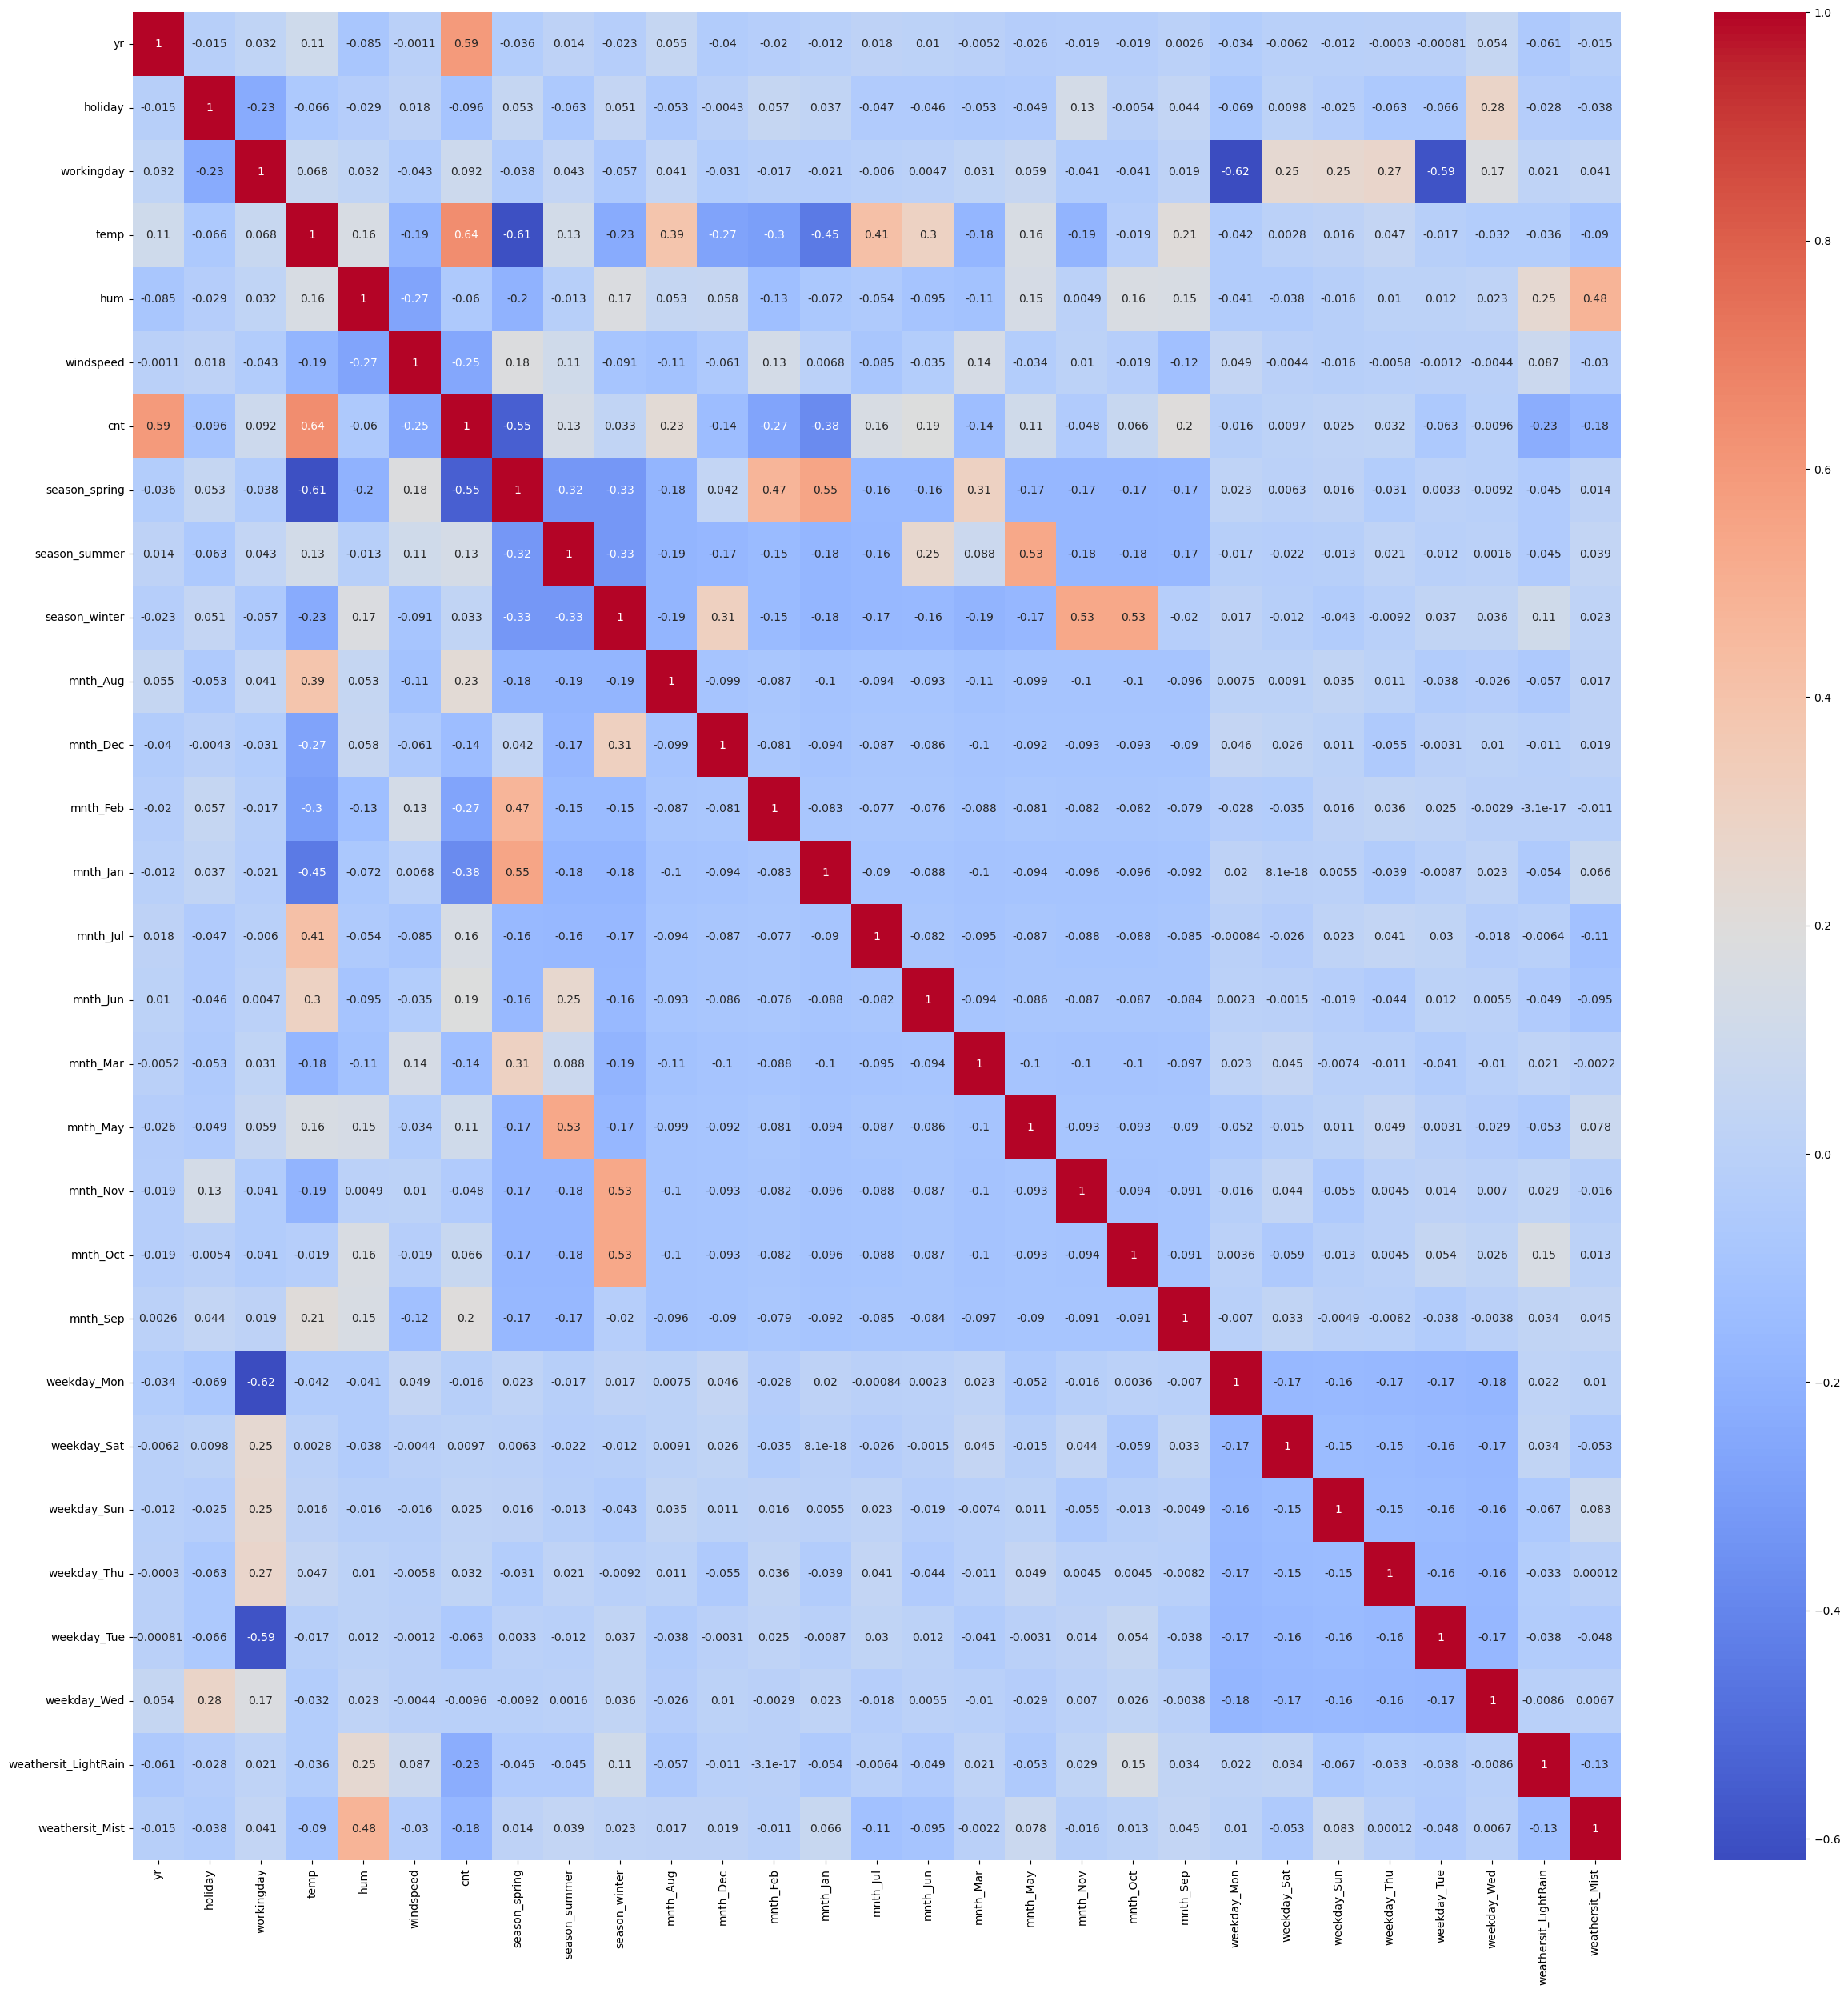

In [37]:
# using heatmap let's try to find out correlated columns
plt.figure(figsize=(30,30))
sns.heatmap(bs_train.corr(),annot=True,cmap="coolwarm")
plt.show()

- cnt has high correlation with temp and yr
- There is no significant correlation observed between independant variables

## Setp3 - Training the model

In [40]:
# Divide training set into X_train and y_train
y_train = bs_train.pop('cnt')
X_train = bs_train

In [41]:
# Fit the model on training set
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

### Use RFE (Recursive Feature Ellimination)

In [43]:
# Selecting top 15 features using RFE
rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [44]:
# check which features are suggested
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 6),
 ('mnth_Dec', False, 3),
 ('mnth_Feb', False, 4),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 13),
 ('mnth_Mar', False, 14),
 ('mnth_May', False, 5),
 ('mnth_Nov', False, 2),
 ('mnth_Oct', False, 10),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', True, 1),
 ('weekday_Sat', False, 12),
 ('weekday_Sun', False, 11),
 ('weekday_Thu', False, 9),
 ('weekday_Tue', False, 7),
 ('weekday_Wed', False, 8),
 ('weathersit_LightRain', True, 1),
 ('weathersit_Mist', True, 1)]

In [45]:
# check columns selected by RFE
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Jan',
       'mnth_Jul', 'mnth_Sep', 'weekday_Mon', 'weathersit_LightRain',
       'weathersit_Mist'],
      dtype='object')

In [46]:
# check columns not selected by RFE
X_train.columns[~rfe.support_]

Index(['mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jun', 'mnth_Mar', 'mnth_May',
       'mnth_Nov', 'mnth_Oct', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed'],
      dtype='object')

In [47]:
# Function to create model and print summary using statsmodel api
# This function takes columns list as argument
def create_model_sm(cols):
    # Add constant (required by statsmodel)
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return [lm,X_train_sm]

In [48]:
# Function to calculate and print VIF
# This function takes columns list as argument
def calulate_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF',ascending=False)
    return vif

### Model create attempt 1

In [50]:
# Select all 15 features and create model on training dataset
cols = X_train.columns[rfe.support_]
lm, X_train_sm = create_model_sm(cols)
calulate_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          2.31e-191
Time:                        22:37:47   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2510 

,Features,VIF
4,hum,29.40
3,temp,17.77
2,workingday,5.31
5,windspeed,4.73
6,season_spring,4.53
8,season_winter,3.48
7,season_summer,2.84
14,weathersit_Mist,2.29
0,yr,2.09
12,weekday_Mon,1.98


### Model create attempt 2

In [52]:
# hum has highest VIF of 29.40 so lets try removing this feature
vars_to_be_removed = ['hum']
cols = list(set(X_train.columns[rfe.support_]) - set(vars_to_be_removed))
lm, X_train_sm = create_model_sm(cols)
calulate_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.3
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          7.33e-189
Time:                        22:37:47   Log-Likelihood:                 511.16
No. Observations:                 510   AIC:                            -992.3
Df Residuals:                     495   BIC:                            -928.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1737 

,Features,VIF
4,temp,7.07
3,workingday,5.24
0,windspeed,4.67
5,season_spring,3.08
13,season_summer,2.33
7,yr,2.08
11,season_winter,1.99
9,weekday_Mon,1.97
6,mnth_Jan,1.62
2,mnth_Jul,1.59


### Model create attempt 3

In [54]:
# temp has highest VIF of 7.07 so lets try removing this feature
vars_to_be_removed = ['hum','temp']
cols = list(set(X_train.columns[rfe.support_]) - set(vars_to_be_removed))
lm, X_train_sm = create_model_sm(cols)
calulate_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          4.04e-154
Time:                        22:37:47   Log-Likelihood:                 425.72
No. Observations:                 510   AIC:                            -823.4
Df Residuals:                     496   BIC:                            -764.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5448 

,Features,VIF
0,windspeed,4.27
3,workingday,3.83
4,season_spring,2.97
12,season_summer,2.27
10,season_winter,1.99
6,yr,1.91
8,weekday_Mon,1.69
5,mnth_Jan,1.60
9,weathersit_Mist,1.56
2,mnth_Jul,1.30


### Model create attempt 4

In [56]:
# mnth_Jul has highest p-value of 0.645 so lets try removing this feature
vars_to_be_removed = ['hum','temp','mnth_Jul']
cols = list(set(X_train.columns[rfe.support_]) - set(vars_to_be_removed))
lm, X_train_sm = create_model_sm(cols)
calulate_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     147.6
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          3.62e-155
Time:                        22:37:47   Log-Likelihood:                 425.61
No. Observations:                 510   AIC:                            -825.2
Df Residuals:                     497   BIC:                            -770.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5409 

,Features,VIF
10,windspeed,4.12
2,workingday,3.54
1,season_spring,2.68
11,season_summer,2.00
4,yr,1.89
9,season_winter,1.78
6,weekday_Mon,1.62
3,mnth_Jan,1.60
8,weathersit_Mist,1.56
5,mnth_Sep,1.20


### Model create attempt 5

In [58]:
# holiday has highest p-value of 0.079 so try removing this feature
vars_to_be_removed = ['hum','temp','mnth_Jul','holiday']
cols = list(set(X_train.columns[rfe.support_]) - set(vars_to_be_removed))
lm, X_train_sm = create_model_sm(cols)
calulate_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     160.0
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          1.30e-155
Time:                        22:37:47   Log-Likelihood:                 424.03
No. Observations:                 510   AIC:                            -824.1
Df Residuals:                     498   BIC:                            -773.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5334 

,Features,VIF
9,windspeed,4.04
2,workingday,3.29
1,season_spring,2.65
10,season_summer,1.99
4,yr,1.88
8,season_winter,1.73
3,mnth_Jan,1.60
6,weekday_Mon,1.56
7,weathersit_Mist,1.56
5,mnth_Sep,1.18


- This model seems to be statistically correct as all p-values are below 0.05 and VIF values are 5

## Step4 - Residual Analysis

In [61]:
# Lets predict the output on training dataset using model
y_train_cnt = lm.predict(X_train_sm)

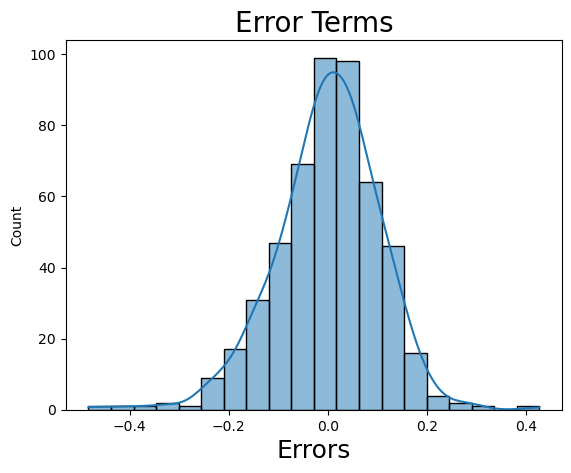

In [62]:
# Plot the histogram of the error terms
ax = sns.histplot((y_train-y_train_cnt), bins=20, kde=True)
ax.set_title('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18) 
plt.show()

- Error terms are normally distributed with mean equal to zero

## Step5 - Predictions and evaluation on the test dataset

In [65]:
# scale the continuous variables from test set with scaler 
bs_test[continuous_vars] = scaler.transform(bs_test[continuous_vars])

In [66]:
# prepare X_test and y_test from our test dataset
y_test = bs_test.pop('cnt')
X_test = bs_test

In [67]:
# Now let's use our model to make predictions.

# Adding a constant variable in test set 
X_test_sm = sm.add_constant(X_test[cols])

In [68]:
# Making predictions on test set
y_pred = lm.predict(X_test_sm)

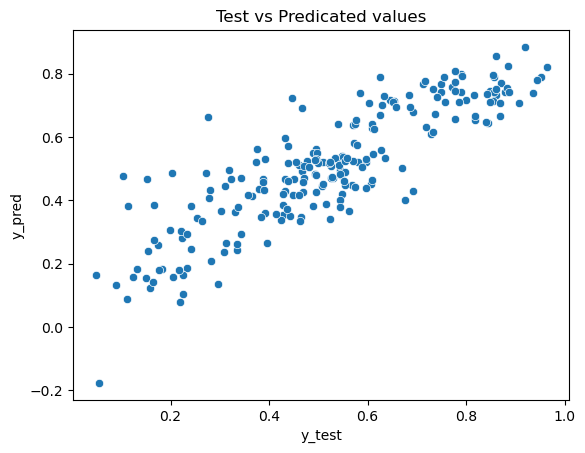

In [69]:
# Check relation between y_test and y_pred 
ax=sns.scatterplot(x=y_test,y=y_pred)
ax.set_title('Test vs Predicated values')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

- y_test and y_pred have linear relation. This indicates model is accurately predicting values close to original values from test set

In [71]:
# Find R-squred on test set
r2_score(y_true=y_test,y_pred=y_pred)

0.7409269375982523

- Adjusted-R-squared of the model on training set is 0.77 and r2 score on test set is 0.74